# Experiment 1
## Image classification from scratch
### Introduction
This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.
### Setup

In [53]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

# Load the dataset
dataset_name = "stanford_dogs"
dataset, info = tfds.load(dataset_name, split="train", with_info=True, as_supervised=True)

# Print dataset info
print(info)


tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\stanford_dogs\\0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
 

### Generate a Dataset

In [55]:
image_size = (180, 180)
batch_size = 128
seed = 1337

def preprocess(image, label):
    image = tf.image.resize(image, image_size)
    image = image
    return image, label

train_ds, val_ds = tfds.load(dataset_name, split=["train[:80%]", "train[80%:]"], as_supervised=True)
train_ds = train_ds.map(preprocess).batch(batch_size).shuffle(seed)
val_ds = val_ds.map(preprocess).batch(batch_size)


### Visualize the data
Here are the first 9 images in the training dataset.

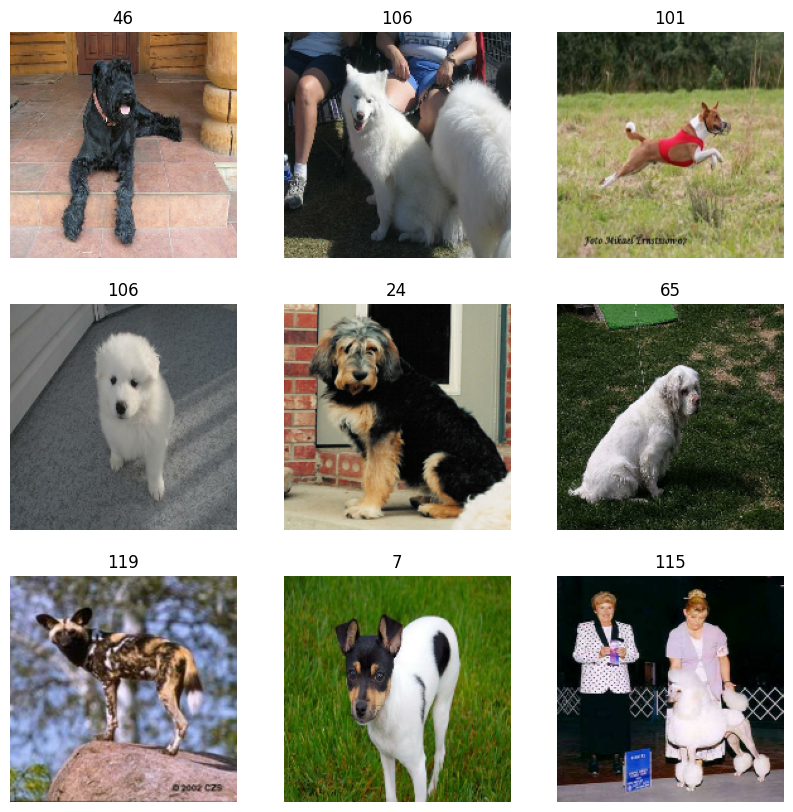

In [56]:
# Could use tdfs.show_example but only works before batching
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [57]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset:

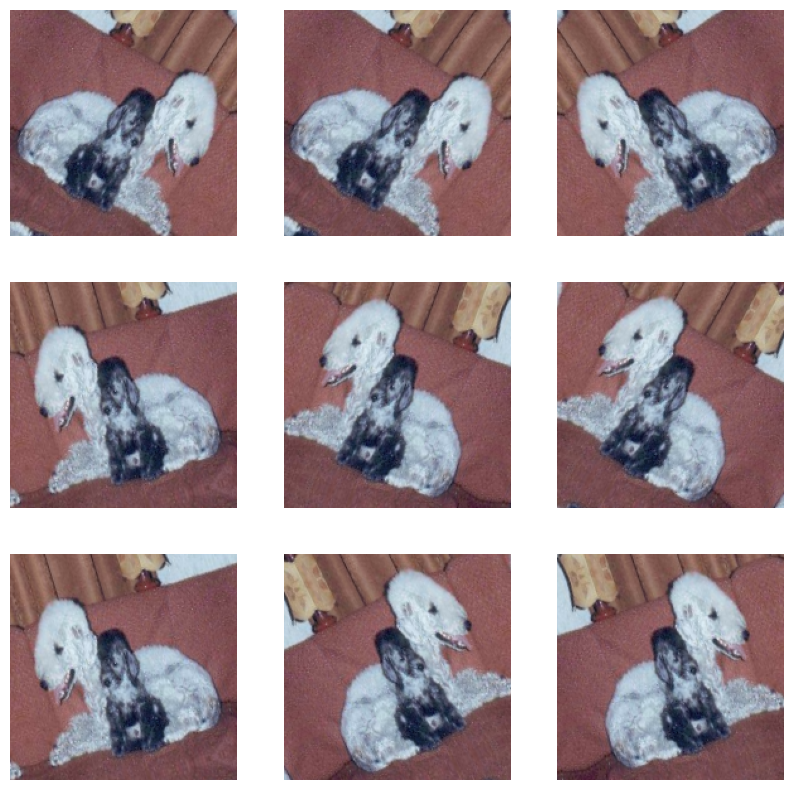

In [58]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.
___
### Two options to preprocess the data
There are two ways you could be using the data_augmentation preprocessor:

**Option 1**: Make it part of the model, like this:

In [59]:
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
# ...  # Rest of the model

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this may be a good option.

**Option 2**: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

In [60]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y))

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

___
### Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [61]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:
- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # Change output layer for multi-class classification (120 dog breeds)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=120)
keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


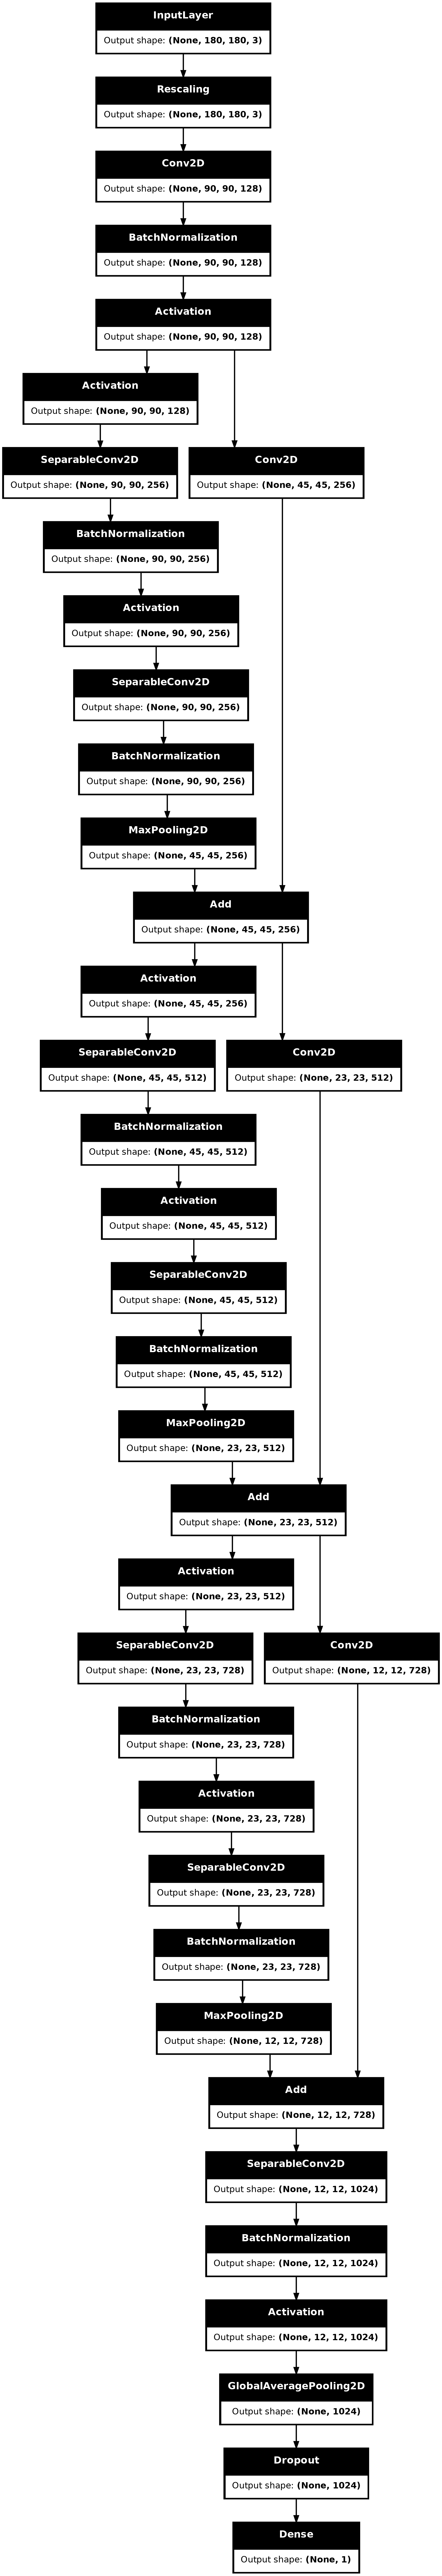

___
### Train the model

In [ ]:
# Test if i can use GPU
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [66]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Modification for experiment 1
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)
model.save("experiment1_model.keras") # Save the model

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 530s 7s/step - acc: 0.0260 - loss: 4.6650 - val_acc: 0.0071 - val_loss: 4.7878
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 527s 7s/step - acc: 0.0396 - loss: 4.5146 - val_acc: 0.0071 - val_loss: 4.7900
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 527s 7s/step - acc: 0.0511 - loss: 4.4146 - val_acc: 0.0071 - val_loss: 4.7964
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 548s 7s/step - acc: 0.0656 - loss: 4.3028 - val_acc: 0.0088 - val_loss: 4.8168
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 546s 7s/step - acc: 0.0810 - loss: 4.2143 - val_acc: 0.0117 - val_loss: 4.8681
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 540s 7s/step - acc: 0.0920 - loss: 4.1176 - val_acc: 0.0100 - val_loss: 4.9687
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 531s 7s/step - acc: 0.1033 - loss: 4.0347 - val_acc: 0.0129 - val_loss: 5.0605
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - acc: 0.1103 - loss: 3.9479 - val_acc: 0.0125 - val_loss: 5.1701
Epoch 9/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - acc: 0.1299

### Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")